In [3]:
from keras.utils import to_categorical, np_utils
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, Input
from keras.layers import (Dense, Reshape, Activation,
                          LSTM, Convolution2D, Flatten, 
                          MaxPooling1D, MaxPooling2D, Dropout, Bidirectional, BatchNormalization, GlobalAveragePooling2D)
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

In [4]:
def convert_format(file):
    df = pd.read_csv(file,header=None)
    seqs = zip(df[2],df[1])
    seqs = list(seqs)
    seqs = list(map(list, seqs))
    
    for i in range(len(seqs)):
        if len(seqs[i][0]) > 100:
            seqs[i][0] = seqs[i][0][:100]
            seqs[i][1] = seqs[i][1][:100]
    
    base_to_value = {45 : 48 ,65 : 49, 71 : 50 , 67 : 51 , 84 : 52}

    seqs = list(map(lambda x: [[int(i.upper().translate(base_to_value)) for i in x[0]],
                                  [int(i.upper().translate(base_to_value)) for i in x[1]]], seqs ))
    
   
    seqs = to_categorical(seqs)
    return seqs
    

In [5]:
os.chdir('/Users/beth/Desktop/MetisProject5data_2/')

In [6]:
normal_bladder = convert_format("bladder_normal.csv")
normal_breast = convert_format("breast_normal.csv")
normal_colorectal = convert_format("colorectal_normal.csv")
normal_glioblastoma = convert_format("glioblastoma_normal.csv")
normal_glioma = convert_format("glioma_normal.csv")
normal_lung = convert_format("lung_normal.csv")
normal_pancreatic = convert_format("pancreatic_normal.csv")
normal_prostate = convert_format("prostate_normal.csv")
normal_renal = convert_format("renal_normal.csv")
normal_skin = convert_format("skin_normal.csv")
normal_stomach = convert_format("stomach_normal.csv")
normal_uterine = convert_format("uterine_normal.csv")
normal_liver = convert_format("liver_normal.csv")

In [7]:
tumor_bladder = convert_format("bladder_tumor.csv")
tumor_breast = convert_format("breast_tumor.csv")
tumor_colorectal = convert_format("colorectal_tumor.csv")
tumor_glioblastoma = convert_format("glioblastoma_tumor.csv")
tumor_glioma = convert_format("glioma_tumor.csv")
tumor_lung = convert_format("lung_tumor.csv")
tumor_pancreatic = convert_format("pancreatic_tumor.csv")
tumor_prostate = convert_format("prostate_tumor.csv")
tumor_renal = convert_format("renal_tumor.csv")
tumor_skin = convert_format("skin_tumor.csv")
tumor_stomach = convert_format("stomach_tumor.csv")
tumor_uterine = convert_format("uterine_tumor.csv")
tumor_liver = convert_format("liver_tumor.csv")

In [8]:
normal_glio = np.concatenate([normal_glioma,normal_glioblastoma],axis=0)
tumor_glio = np.concatenate([tumor_glioma,tumor_glioblastoma],axis=0)

In [9]:
del normal_glioma,normal_glioblastoma,tumor_glioma,tumor_glioblastoma

In [10]:
np.random.seed(11)

In [11]:
def train_test_split(array):
    indices=np.random.randint(array.shape[0], size=2000)
    test = array[indices]
    train = array[[i for i in range(array.shape[0]) if not i in indices]]
    return test, train

In [12]:
bladder_test, bladder_train = train_test_split(tumor_bladder)
del tumor_bladder
breast_test, breast_train = train_test_split(tumor_breast)
del tumor_breast
colorectal_test, colorectal_train = train_test_split(tumor_colorectal)
del tumor_colorectal

In [13]:
glio_test, glio_train = train_test_split(tumor_glio)
del tumor_glio
lung_test, lung_train = train_test_split(tumor_lung)
del tumor_lung
pancreatic_test, pancreatic_train = train_test_split(tumor_pancreatic)
del tumor_pancreatic

In [14]:
renal_test, renal_train = train_test_split(tumor_renal)
del tumor_renal
prostate_test, prostate_train = train_test_split(tumor_prostate)
del tumor_prostate
skin_test, skin_train = train_test_split(tumor_skin)
del tumor_skin
stomach_test, stomach_train = train_test_split(tumor_stomach)
del tumor_stomach
uterine_test, uterine_train = train_test_split(tumor_uterine)
del tumor_uterine
liver_test, liver_train = train_test_split(tumor_liver)
del tumor_liver

In [15]:
bladder_test_normal, bladder_train_normal = train_test_split(normal_bladder)
del normal_bladder
breast_test_normal, breast_train_normal = train_test_split(normal_breast)
del normal_breast
colorectal_test_normal, colorectal_train_normal = train_test_split(normal_colorectal)
del normal_colorectal
glio_test_normal, glio_train_normal = train_test_split(normal_glio)
del normal_glio
lung_test_normal, lung_train_normal = train_test_split(normal_lung)
del normal_lung
pancreatic_test_normal, pancreatic_train_normal = train_test_split(normal_pancreatic)
del normal_pancreatic
renal_test_normal, renal_train_normal = train_test_split(normal_renal)
del normal_renal
prostate_test_normal, prostate_train_normal = train_test_split(normal_prostate)
del normal_prostate
skin_test_normal, skin_train_normal = train_test_split(normal_skin)
del normal_skin
stomach_test_normal, stomach_train_normal = train_test_split(normal_stomach)
del normal_stomach
uterine_test_normal, uterine_train_normal = train_test_split(normal_uterine)
del normal_uterine
liver_test_normal, liver_train_normal = train_test_split(normal_liver)
del normal_liver

In [16]:
y_train_tumor = [1]*bladder_train.shape[0]+[2]*breast_train.shape[0]+[3]*colorectal_train.shape[0]+[4]*glio_train.shape[0]+[5]*lung_train.shape[0]\
+[6]*pancreatic_train.shape[0]+[7]*renal_train.shape[0]+[8]*prostate_train.shape[0]+[9]*skin_train.shape[0]+[10]*stomach_train.shape[0]\
+[11]*uterine_train.shape[0]+[12]*liver_train.shape[0]

In [17]:
len(y_train_tumor)

1949597

In [18]:
tumor = np.concatenate([bladder_train,breast_train,colorectal_train],axis=0)

In [19]:
tumor = np.concatenate([tumor,glio_train],axis=0)

In [20]:
del bladder_train, breast_train, colorectal_train, glio_train

In [21]:
tumor = np.concatenate([tumor,lung_train,pancreatic_train,renal_train],axis=0)

In [22]:
del lung_train, pancreatic_train, renal_train

In [23]:
tumor = np.concatenate([tumor,prostate_train,skin_train,stomach_train],axis=0)

In [24]:
del prostate_train,skin_train,stomach_train

In [25]:
tumor = np.concatenate([tumor,uterine_train],axis=0)

In [26]:
del uterine_train

In [27]:
tumor = np.concatenate([tumor,liver_train],axis=0)
del liver_train

In [28]:
tumor.shape

(1949597, 2, 100, 5)

In [29]:
from collections import defaultdict

In [30]:
class_weights = defaultdict(int)
for i in range(1,13):
    class_weights[i]=y_train_tumor.count(i)

In [31]:
class_weights

defaultdict(int,
            {1: 107117,
             2: 107389,
             3: 207692,
             4: 87689,
             5: 168669,
             6: 22879,
             7: 17011,
             8: 23083,
             9: 324124,
             10: 150114,
             11: 697337,
             12: 36493})

In [32]:
y_train_normal = [0]*(bladder_train_normal.shape[0]+breast_train_normal.shape[0]+colorectal_train_normal.shape[0]+glio_train_normal.shape[0]+lung_train_normal.shape[0]\
+pancreatic_train_normal.shape[0]+renal_train_normal.shape[0]+prostate_train_normal.shape[0]+skin_train_normal.shape[0]+stomach_train_normal.shape[0]+uterine_train_normal.shape[0]+liver_train_normal.shape[0])


In [33]:
len(y_train_normal)

1951011

In [34]:
normal = np.concatenate([bladder_train_normal,breast_train_normal,colorectal_train_normal],axis=0)

In [35]:
normal = np.concatenate([normal,glio_train_normal],axis=0)

In [36]:
del bladder_train_normal, breast_train_normal, colorectal_train_normal, glio_train_normal

In [37]:
normal = np.concatenate([normal,lung_train_normal,pancreatic_train_normal,renal_train_normal],axis=0)

In [38]:
del lung_train_normal, pancreatic_train_normal, renal_train_normal

In [39]:
normal = np.concatenate([normal,prostate_train_normal,skin_train_normal,stomach_train_normal],axis=0)

In [40]:
del prostate_train_normal,skin_train_normal,stomach_train_normal

In [41]:
normal = np.concatenate([normal,uterine_train_normal, liver_train_normal],axis=0)
del uterine_train_normal, liver_train_normal

In [42]:
normal.shape[0]

1951011

In [43]:
class_weights[0]=normal.shape[0]

In [44]:
class_weights

defaultdict(int,
            {1: 107117,
             2: 107389,
             3: 207692,
             4: 87689,
             5: 168669,
             6: 22879,
             7: 17011,
             8: 23083,
             9: 324124,
             10: 150114,
             11: 697337,
             12: 36493,
             0: 1951011})

In [45]:
for key in class_weights.keys():
    class_weights[key]=class_weights[0]/class_weights[key]

In [46]:
class_weights

defaultdict(int,
            {1: 18.213831604693933,
             2: 18.167698740094423,
             3: 9.393770583363827,
             4: 22.249210277229754,
             5: 11.567098874126247,
             6: 85.27518685257223,
             7: 114.69114102639469,
             8: 84.52155265780011,
             9: 6.019335192704027,
             10: 12.996862384587713,
             11: 2.7978022104090274,
             12: 53.46260926753076,
             0: 1.0})

In [47]:
y_train = y_train_tumor + y_train_normal

In [48]:
len(y_train)

3900608

In [49]:
 X_train = np.concatenate([tumor,normal],axis=0)
del tumor,normal

In [50]:
X_train.shape

(3900608, 2, 100, 5)

In [51]:
y_train = to_categorical(y_train)

In [52]:
del train_test_split
from sklearn.model_selection import train_test_split

In [53]:
X_train.shape

(3900608, 2, 100, 5)

In [54]:
y_train.shape

(3900608, 13)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=11, stratify=y_train)

In [4]:
model=Sequential()

model.add(Convolution2D(input_shape=(2,100,5),
                       filters=100,
                       kernel_size=(2,3),
                       padding="same",
                       activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=2,
                       padding="same"))

model.add(Convolution2D(filters=50,
                       kernel_size=(2,2),
                       padding="same",
                       activation="relu"))
model.add(MaxPooling2D(pool_size=2,
                       padding="same"))
model.add(BatchNormalization(axis=-1))

model.add(GlobalAveragePooling2D())

model.add(Dense(units=13))
model.add(Activation('softmax'))

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2, 100, 100)       3100      
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 100, 100)       400       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 50, 100)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 50, 50)         20050     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 25, 50)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 25, 50)         200       
_________________________________________________________________
global_average_pooling2d_2 ( (None, 50)               

In [62]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [90]:
callback_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta = 0.2,
                              patience=1, min_lr=0.00001)

In [91]:
optimizer = Adam(lr=0.001)

In [72]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_crossentropy','accuracy'])

In [73]:
model.fit(X_train, y_train, epochs=100, batch_size=5000,
              validation_data=(X_val, y_val),verbose=True, callbacks=[callback,callback_lr], class_weight=class_weights)

Train on 3510547 samples, validate on 390061 samples
Epoch 1/100
3510547/3510547 [==============================] - 2973s 847us/step - loss: 14.4177 - categorical_crossentropy: 1.7163 - accuracy: 0.5166 - val_loss: 1.6740 - val_categorical_crossentropy: 1.6740 - val_accuracy: 0.5344
Epoch 2/100
3510547/3510547 [==============================] - 2791s 795us/step - loss: 14.3659 - categorical_crossentropy: 1.7052 - accuracy: 0.5173 - val_loss: 1.7432 - val_categorical_crossentropy: 1.7432 - val_accuracy: 0.5145
Epoch 3/100
3510547/3510547 [==============================] - 2859s 814us/step - loss: 14.2848 - categorical_crossentropy: 1.6933 - accuracy: 0.5188 - val_loss: 1.6950 - val_categorical_crossentropy: 1.6950 - val_accuracy: 0.5173
Epoch 4/100
1610000/3510547 [============>.................] - ETA: 26:37 - loss: 14.2806 - categorical_crossentropy: 1.6896 - accuracy: 0.5185

KeyboardInterrupt: 

In [89]:
#model_json = model.to_json()
with open("model_more_filters.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_more_filters.h5")

## Predictions on Validation Set

In [74]:
predictions = model.predict(X_val)

In [467]:
from sklearn.metrics import confusion_matrix

In [75]:
predictions_01 = np.argmax(predictions,axis=1) 

In [76]:
pd.Series(predictions_01).value_counts()

0     156424
9      41067
8      31071
12     30297
6      26310
11     24680
5      20843
1      18799
10     17534
7      14789
4       5165
3       2218
2        864
dtype: int64

In [77]:
pd.Series(np.argmax(y_val,axis=1)).value_counts()

0     195101
11     69734
9      32413
3      20769
5      16867
10     15011
2      10739
1      10712
4       8769
12      3649
8       2308
6       2288
7       1701
dtype: int64

In [78]:
y_val_01= np.argmax(y_val,axis=1)

In [98]:
confusion = confusion_matrix(y_val_01,predictions_01)

In [99]:
confusion_sum=confusion.sum(axis=1)

In [100]:
confusion_sum

array([195101,  10712,  10739,  20769,   8769,  16867,   2288,   1701,
         2308,  32413,  15011,  69734,   3649])

In [101]:
confusion2=[]
for i in range(0,13):
    confusion2.append(confusion[i]/confusion_sum[i])

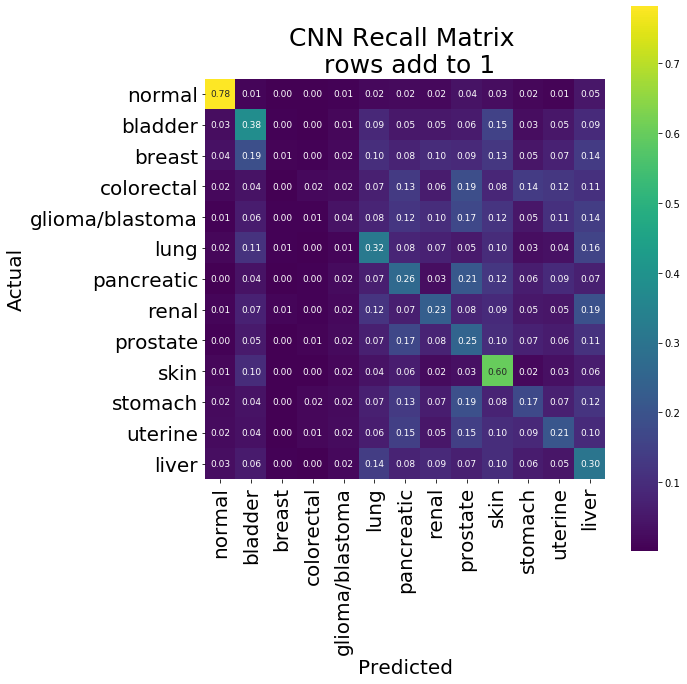

In [103]:
plt.figure(figsize=(10,10))

sns.heatmap(confusion2,square=True,cmap="viridis",annot=True,annot_kws={'size':9},xticklabels=['normal','bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           yticklabels=['normal','bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],fmt='.2f')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('CNN Recall Matrix \n rows add to 1', fontsize=25)
plt.tight_layout()
plt.savefig('recall_more_filters.jpg');

In [104]:
def print_stats(confusion_matrix):
    for i, v in enumerate(['normal','bladder','breast','colorectal',\
                        'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']):
        recall = confusion[i,i]/sum(confusion[i])
        percision = confusion[i,i]/sum(confusion[:,i])
        print("{} recall: {}".format(v,recall))
        print("{} percision: {}".format(v,percision))
        print("\n")

In [105]:
print_stats(confusion)

normal recall: 0.781892455702431
normal percision: 0.9752211936787194


bladder recall: 0.3817214339058999
bladder percision: 0.21751156976434916


breast recall: 0.0075426017320048425
breast percision: 0.09375


colorectal recall: 0.0174298232943329
colorectal percision: 0.16321009918845808


glioma/blastoma recall: 0.03808872163302543
glioma/blastoma percision: 0.06466602129719265


lung recall: 0.3172466947293532
lung percision: 0.2567288778007005


pancreatic recall: 0.263986013986014
pancreatic percision: 0.022957050551121246


renal recall: 0.2328042328042328
renal percision: 0.026776658327135033


prostate recall: 0.25086655112651646
prostate percision: 0.018634739789514337


skin recall: 0.598926356708728
skin percision: 0.472715318869165


stomach recall: 0.17440543601359004
stomach percision: 0.1493099121706399


uterine recall: 0.20938136346688846
uterine percision: 0.591612641815235


liver recall: 0.3030967388325569
liver percision: 0.03650526454764498




# Predictions on hold-out test set

In [106]:
final_test = np.concatenate([bladder_test, breast_test, colorectal_test, glio_test, lung_test, pancreatic_test,
                            prostate_test, renal_test, skin_test, stomach_test, uterine_test, liver_test])

In [107]:
final_test.shape

(24000, 2, 100, 5)

In [169]:
del bladder_test, breast_test, colorectal_test, glio_test, lung_test, pancreatic_test, prostate_test, renal_test, skin_test, stomach_test, uterine_test, liver_test

In [108]:
final_normal_test = np.concatenate([bladder_test_normal, breast_test_normal, colorectal_test_normal,
                            glio_test_normal, lung_test_normal, prostate_test_normal, pancreatic_test_normal, renal_test_normal,
                            skin_test_normal, stomach_test_normal, uterine_test_normal, liver_test_normal])

In [109]:
final_test_true = [1]*2000+[2]*2000+[3]*2000+[4]*2000+[5]*2000+[6]*2000+[8]*2000+[7]*2000+[9]*2000+[10]*2000+[11]*2000+[12]*2000

In [110]:
final_normal_test_true = [0]*24000

In [111]:
final_test_true = to_categorical(final_test_true)

In [112]:
preds = model.predict(final_test)

In [113]:
predictions_01 = np.argmax(preds,axis=1) 

In [114]:
pd.Series(predictions_01).value_counts()

9     3497
12    3258
8     3111
6     2814
5     2436
1     2314
11    1934
7     1903
10    1598
4      515
0      369
3      150
2      101
dtype: int64

In [115]:
pd.Series(np.argmax(final_test_true,axis=1)).value_counts()

12    2000
11    2000
10    2000
9     2000
8     2000
7     2000
6     2000
5     2000
4     2000
3     2000
2     2000
1     2000
dtype: int64

In [116]:
y_val_01= np.argmax(final_test_true,axis=1)

In [227]:
from sklearn.metrics import confusion_matrix

In [117]:
confusion = confusion_matrix(y_val_01,predictions_01)

In [118]:
confusion = confusion[1:,:]

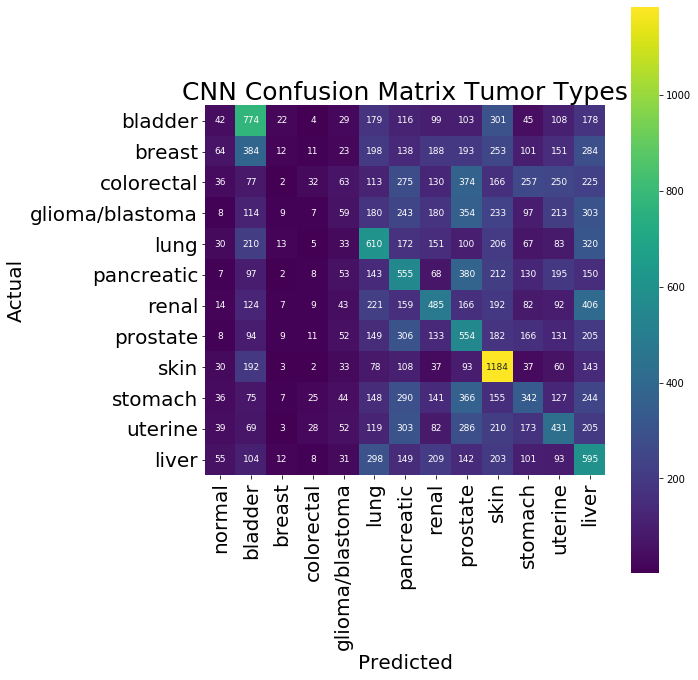

In [119]:
plt.figure(figsize=(10,10))

sns.heatmap(confusion,square=True,cmap="viridis",annot=True,annot_kws={'size':9},xticklabels=['normal','bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           yticklabels=['bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],fmt='.0f')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('CNN Confusion Matrix Tumor Types', fontsize=25)
plt.tight_layout()
plt.savefig('more_filters_confusion.jpg');

In [132]:
preds_normal = model.predict(final_normal_test)

In [133]:
predictions_01 = np.argmax(preds_normal,axis=1) 

In [134]:
pd.Series(predictions_01).value_counts()

0     18625
12     1162
8       945
9       648
6       512
5       472
7       465
10      410
1       336
11      229
4       137
3        36
2        23
dtype: int64

In [135]:
y_val_01= np.zeros(24000)

In [136]:
confusion = confusion_matrix(y_val_01,predictions_01)

In [139]:
confusion

array([[18625,   336,    23,    36,   137,   472,   512,   465,   945,
          648,   410,   229,  1162],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,

In [141]:
confusion2 = confusion[0,:]

In [142]:
confusion2

array([18625,   336,    23,    36,   137,   472,   512,   465,   945,
         648,   410,   229,  1162])

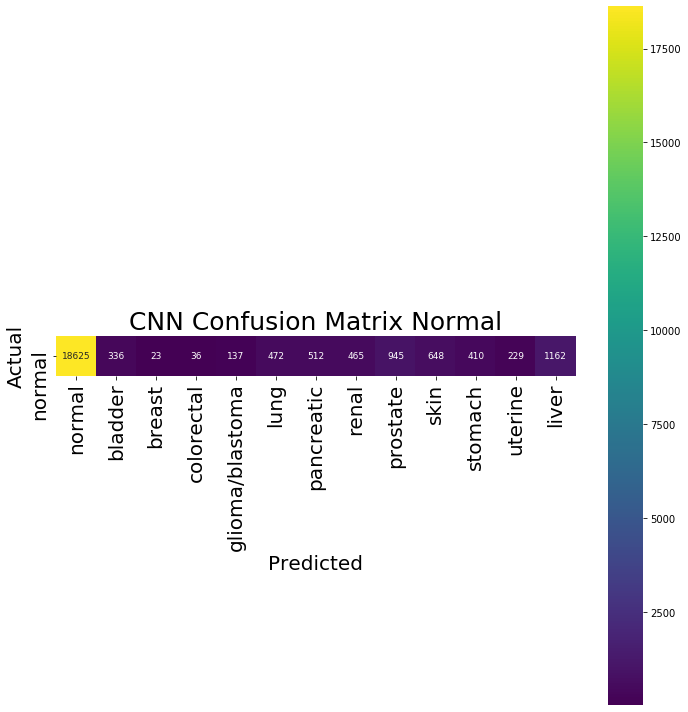

In [143]:
plt.figure(figsize=(10,10))

sns.heatmap(confusion2.reshape([-1,13]),square=True,cmap="viridis",annot=True,annot_kws={'size':9},xticklabels=['normal','bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           yticklabels=['normal'],fmt='.0f')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('CNN Confusion Matrix Normal', fontsize=25)
plt.tight_layout()
plt.savefig('more_filters_confusion_normal.jpg');

In [145]:
preds = model.predict(np.concatenate([final_test,final_normal_test],axis=0))

In [147]:
final_test_true = [1]*2000+[2]*2000+[3]*2000+[4]*2000+[5]*2000+[6]*2000+[8]*2000+[7]*2000+[9]*2000+[10]*2000+[11]*2000+[12]*2000

In [148]:
final_normal_test_true = [0]*24000

In [149]:
true = final_test_true + final_normal_test_true

In [150]:
true=to_categorical(true)

In [151]:
predictions_01 = np.argmax(preds,axis=1) 

In [154]:
y_val_01= np.argmax(true,axis=1)

In [155]:
confusion = confusion_matrix(y_val_01,predictions_01)

In [158]:
def print_stats(confusion_matrix):
    for i, v in enumerate(['normal','bladder','breast','colorectal',\
                        'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']):
        recall = confusion[i,i]/sum(confusion[i])
        percision = confusion[i,i]/sum(confusion[:,i])
        print("{} recall: {}".format(v,recall))
        print("{} precision: {}".format(v,percision))
        print("\n")

In [159]:
print_stats(confusion)

normal recall: 0.7760416666666666
normal precision: 0.9805728124670948


bladder recall: 0.387
bladder precision: 0.2920754716981132


breast recall: 0.006
breast precision: 0.0967741935483871


colorectal recall: 0.016
colorectal precision: 0.17204301075268819


glioma/blastoma recall: 0.0295
glioma/blastoma precision: 0.09049079754601227


lung recall: 0.305
lung precision: 0.2097661623108666


pancreatic recall: 0.2775
pancreatic precision: 0.16686710763680096


renal recall: 0.2425
renal precision: 0.2048141891891892


prostate recall: 0.277
prostate precision: 0.13658777120315582


skin recall: 0.592
skin precision: 0.2856453558504222


stomach recall: 0.171
stomach precision: 0.17031872509960158


uterine recall: 0.2155
uterine precision: 0.19926028663892742


liver recall: 0.2975
liver precision: 0.1346153846153846




# Getting signatures

In [219]:
from keras.models import load_model

In [220]:
os.chdir("/Users/beth/Desktop/MetisProject5data_2/")

In [221]:
model.load_weights('model_more_filters.h5')

In [160]:
amp_layer_weights = model.layers[-2].get_weights()[0]

In [161]:
model.layers[-2]

In [162]:
model.layers[-3]

In [163]:
model.layers[-4]

In [164]:
model_for_heatmaps = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 

For the signatures I will use the entire training + validation set

In [165]:
X_train = np.concatenate([X_train,X_val],axis=0)

In [166]:
X_train.shape

(3900608, 2, 100, 5)

In [167]:
last_conv_output, predictions = model_for_heatmaps.predict(X_train)

In [169]:
last_conv_output[1].shape

(1, 25, 50)

In [170]:
amp_layer_weights.shape

(50, 13)

In [171]:
def seq_font_size(seq):
    return .137*seq.count('A')+.154*seq.count('T')+.13*seq.count('C')+.126*seq.count('G')+.138*seq.count("X")

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
def get_signatures(tumor_type,predictions,last_conv_output,amp_layer_weights,X_val):
    tumor_list = ['normal','bladder','breast','colorectal','glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']
    i = tumor_list.index(tumor_type)
    value_to_base = {48: 88, 49 : 65, 50 : 71 , 51 : 67 , 52 : 84}
    top_examples = np.argsort(predictions[:,i])[-10:]
    fig, ax = plt.subplots(10,1,figsize=(17,10))
    for k,j in enumerate(top_examples):
        weights = amp_layer_weights[:, i]
        final_output = np.dot(last_conv_output[j], weights)
        ref_seq = np.argmax(X_val[j][0],axis=1)
        ref_seq = [''.join(ref_seq.astype('str').tolist())][0].translate(value_to_base)
        seq = np.argmax(X_val[j][1],axis=1)
        seq = [''.join(seq.astype('str').tolist())][0].translate(value_to_base)
        sns.heatmap(final_output.reshape([-1,25]),cbar=None,cmap="summer", ax=ax[k])
        ax[k].axis('off')
        ax[k].text(0.04,0.8,seq,fontsize=seq_font_size(seq))
        ax[k].text(0.04,0.4,ref_seq,fontsize=seq_font_size(ref_seq))
        

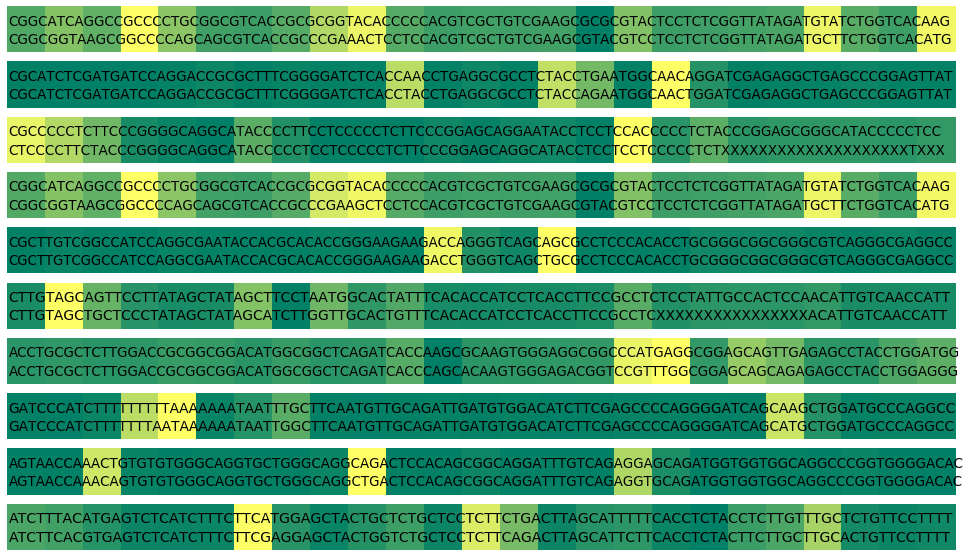

In [232]:
get_signatures('liver',predictions,last_conv_output,amp_layer_weights,X_train)

In [106]:
test = np.argsort(predictions[:,1])

In [110]:
test[-1]

753133

In [111]:
predictions[753133]

array([3.2946768e-16, 9.5183462e-01, 2.1618774e-02, 3.1709729e-04,
       1.7029053e-03, 7.9509113e-03, 1.7084864e-03, 1.0385570e-03,
       4.3292466e-04, 1.2406209e-02, 2.6206110e-04, 2.6137871e-04,
       4.6602992e-04], dtype=float32)

In [208]:
def get_signatures_seqs(tumor_type,predictions,last_conv_output,amp_layer_weights,X_val):
    tumor_list = ['normal','bladder','breast','colorectal','glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']
    t = tumor_list.index(tumor_type)
    value_to_base = {48: 45, 49 : 65, 50 : 71 , 51 : 67 , 52 : 84}
    top_examples = np.argsort(predictions[:,t])[-1000:]
    top_seqs = []
    for k,j in enumerate(top_examples):
        weights = amp_layer_weights[:, t]
        final_output = np.dot(last_conv_output[j], weights)
        final_output = final_output
        ref_seq = np.argmax(X_val[j][0],axis=1)
        ref_seq = [''.join(ref_seq.astype('str').tolist())][0].translate(value_to_base)
        ref_seq=np.array([ref_seq[i:i+4] for i in range(0, len(ref_seq), 4)])
        ref_seq = ref_seq.reshape([-1,25])
        seq = np.argmax(X_val[j][1],axis=1)
        seq = [''.join(seq.astype('str').tolist())][0].translate(value_to_base)
        seq=np.array([seq[i:i+4] for i in range(0, len(seq), 4)])
        seq = seq.reshape([-1,25])
    
        skip=0
        for i in range(len(final_output[0])):
            if i + skip > len(final_output[0])-1:
                break
                
            if final_output[0][i+skip] > 0:
                importance = final_output[0][i+skip]
                x = seq[0][i+skip]
                xx = ref_seq[0][i+skip]
                skip=0
                
                if i > len(final_output[0])-2:
                        break
                        
                while final_output[0][i + 1] > 0:
                    importance = importance + final_output[0][i+1]
                    skip=skip+1
                    i = i + 1
                    y = seq[0][i]
                    yy = ref_seq[0][i]
                    x = x + y
                    xx = xx + yy
                    
                    if i > len(final_output[0])-2:
                        break
                        
                top_seqs.append((xx,x,importance))
                
    top_seqs=pd.DataFrame(top_seqs)
    top_seqs = top_seqs.groupby([0,1]).aggregate({2:['mean','count']})
    top_seqs.columns = top_seqs.columns.get_level_values(1)
    top_seqs['mean*count']=top_seqs['mean']*top_seqs['count']
    return(top_seqs)
        
        

In [209]:
blad_signatures = get_signatures_seqs('bladder',predictions,last_conv_output,amp_layer_weights,X_train)

In [237]:
blad_signatures.sort_values(['mean*count'],ascending=False).head(20)

mean  count   mean*count
0        1                                       
CTCA     CTTA       65.675674     24  1576.216167
ATGAATGA ATAAATAA  105.666430     12  1267.997154
CCTC     CCTG       77.779746     15  1166.696186
GCTC     GCTG       64.944389     17  1104.054607
CTCACTCA CTTACTTA  133.980039      8  1071.840309
TCTC     TCTG       74.685553     14  1045.597740
TTCA     TTTA       57.671157     18  1038.080826
CTGA     CTAA       63.056817     16  1008.909077
CATC     CATG       69.668115     13   905.685501
CTCT     CTGT       74.099516     12   889.194191
CCTCCCTC CCTGCCTG  164.980957      5   824.904785
CTGACTGA CTAACTAA  133.440061      6   800.640366
TCTCTCTC TCTGTCTG  146.826047      5   734.130234
GATGGATG GATAGATA  115.477421      6   692.864525
TTGA     TTAA       60.943041     11   670.373455
CTCT     CTTT       50.724495     13   659.418438
ATCTATCT ATGTATGT  115.538461      5   577.692307
CTCTCTCT CTTTCTTT   93.908843      6   563.453056
GTGA     GTAA       55.898102     10   558.981022
ATGA     ATAA       60.599115      9   545.392036

In [211]:
lung_signatures = get_signatures_seqs('lung',predictions,last_conv_output,amp_layer_weights,X_train)

In [239]:
lung_signatures.sort_values(['mean*count'],ascending=False).head(10)

mean  count  \
0                        1                                             
GGGG                     GTGG                       44.803573      8   
GGTCGGTCCGTG             GGTAGGTAACTG              159.669815      2   
GGTG                     GTTG                       38.266541      8   
GGCCCCAT                 GGCCAAAT                   89.676956      3   
TCCCTCCCCAGGTCAT         TCCATCCAAAGGTCAT          126.131210      2   
GCCTGCCTCGGCCACCCGCG     GCCTGCCTAAGCCACCAGCG      124.771141      2   
ACGATGATGAGGCCCAGGATCTGT ACGATGATGAGTCCCATTATGTGT  117.515015      2   
AGCCAGCCCGAG             AGCCAGCCAGAG               78.167747      3   
CCTCCCTCCCACTTGCGCTGGGTG CCTCCCTCCAACTTGAGCTGGGAG  112.450432      2   
AGAGAGAGGGGCTCACCTGCCGGC AGAGAGAGTGGCTCACATGCCGGC  110.537506      2   

                                                   mean*count  
0                        1                                     
GGGG                     GTGG                      358.428585  
GGTCGGTCCGTG             GGTAGGTAACTG              319.339630  
GGTG                     GTTG                      306.132324  
GGCCCCAT                 GGCCAAAT                  269.030869  
TCCCTCCCCAGGTCAT         TCCATCCAAAGGTCAT          252.262421  
GCCTGCCTCGGCCACCCGCG     GCCTGCCTAAGCCACCAGCG      249.542282  
ACGATGATGAGGCCCAGGATCTGT ACGATGATGAGTCCCATTATGTGT  235.030029  
AGCCAGCCCGAG             AGCCAGCCAGAG              234.503242  
CCTCCCTCCCACTTGCGCTGGGTG CCTCCCTCCAACTTGAGCTGGGAG  224.900864  
AGAGAGAGGGGCTCACCTGCCGGC AGAGAGAGTGGCTCACATGCCGGC  221.075012

In [235]:
skin_signatures = get_signatures_seqs('skin',predictions,last_conv_output,amp_layer_weights,X_train)

In [238]:
skin_signatures.sort_values(['mean*count'],ascending=False).head(10)

mean  count   mean*count
0            1                                           
CTCCCTCC     CTTTCTTT      273.136314      6  1638.817886
CTTCCTTCCTTT CTTTCTTTTTTT  302.177643      4  1208.710571
TTCC         TTTC           83.493270     13  1085.412514
CTTC         CTTT           91.110146     11  1002.211605
TCTCCTTT     TCTTTTTT      161.271838      5   806.359192
TTTCTTTC     TTTTTTTT      168.812729      4   675.250916
CTCC         CTTT          132.571730      5   662.858650
CCGGCCGG     CCAACCAA      218.585027      3   655.755081
AAATGGGA     AAATAAGA      160.861458      4   643.445831
TTTCCCTC     TTTTTCTC      159.043461      4   636.173843

In [214]:
liver_signatures = get_signatures_seqs('liver',predictions,last_conv_output,amp_layer_weights,X_train)

In [215]:
liver_signatures.sort_values(['mean*count'],ascending=False).head(10)

mean  \
0                                                  1                                                                
CTGGCTGGAGCTGCGG                                   CTGGCTGGTGCTGCGG                                     57.427559   
GAGC                                               GTGC                                                 30.717323   
CTGGCGGCCCATGAGGCGGAGCAGTTGAGAGC                   CTGGCGGTCCGTTTGGCGGAGCAGCAGAGAGC                    107.390282   
GTGGGTGGGAGGCGGCCCATGAGGCGGAGCAGTTGAGAGC           GTGGGTGGGAGACGGTCCGTTTGGCGGAGCAGCAGAGAGC            102.729462   
AAGCAAGC                                           ATGCATGC                                             61.303094   
CTATGTCTGCAGGGAGTGTGGGCGGGGCTTTCGCAATAAGTCACACC... CTA--------------------------------------------...   90.664234   
GCCCGCCCTCCCTCCCCAGCCCTCCCCACCCTGCCCGCTCCGCC       GCCCCCCCCCCCCCCCCCGCCCCCCCCCCCCCCCCCCCTCCGCC         89.767197   
CAAGCAAG                                           CATGCATG                                             54.166332   
CAGCAGATGAAA                                       CAGCTGATTTAA                                         80.229065   
GGGCGGCGTCCTCGTTGGCGATGCCCTGGGCGGCGACCTCGTTGGCG... GGGCGGCG---------------------------T-----C-----...   80.125443   

                                                                                                       count  \
0                                                  1                                                           
CTGGCTGGAGCTGCGG                                   CTGGCTGGTGCTGCGG                                        5   
GAGC                                               GTGC                                                    7   
CTGGCGGCCCATGAGGCGGAGCAGTTGAGAGC                   CTGGCGGTCCGTTTGGCGGAGCAGCAGAGAGC                        2   
GTGGGTGGGAGGCGGCCCATGAGGCGGAGCAGTTGAGAGC           GTGGGTGGGAGACGGTCCGTTTGGCGGAGCAGCAGAGAGC                2   
AAGCAAGC                                           ATGCATGC                                                3   
CTATGTCTGCAGGGAGTGTGGGCGGGGCTTTCGCAATAAGTCACACC... CTA--------------------------------------------...      2   
GCCCGCCCTCCCTCCCCAGCCCTCCCCACCCTGCCCGCTCCGCC       GCCCCCCCCCCCCCCCCCGCCCCCCCCCCCCCCCCCCCTCCGCC            2   
CAAGCAAG                                           CATGCATG                                                3   
CAGCAGATGAAA                                       CAGCTGATTTAA                                            2   
GGGCGGCGTCCTCGTTGGCGATGCCCTGGGCGGCGACCTCGTTGGCG... GGGCGGCG---------------------------T-----C-----...      2   

                                                                                                       mean*count  
0                                                  1                                                               
CTGGCTGGAGCTGCGG                                   CTGGCTGGTGCTGCGG                                    287.137794  
GAGC                                               GTGC                                                215.021259  
CTGGCGGCCCATGAGGCGGAGCAGTTGAGAGC                   CTGGCGGTCCGTTTGGCGGAGCAGCAGAGAGC                    214.780563  
GTGGGTGGGAGGCGGCCCATGAGGCGGAGCAGTTGAGAGC           GTGGGTGGGAGACGGTCCGTTTGGCGGAGCAGCAGAGAGC            205.458923  
AAGCAAGC                                           ATGCATGC                                            183.909283  
CTATGTCTGCAGGGAGTGTGGGCGGGGCTTTCGCAATAAGTCACACC... CTA--------------------------------------------...  181.328468  
GCCCGCCCTCCCTCCCCAGCCCTCCCCACCCTGCCCGCTCCGCC       GCCCCCCCCCCCCCCCCCGCCCCCCCCCCCCCCCCCCCTCCGCC        179.534393  
CAAGCAAG                                           CATGCATG                                            162.498997  
CAGCAGATGAAA                                       CAGCTGATTTAA                                        160.458130  
GGGCGGCGTCCTCGTTGGCGATGCCCTGGGCGGCGACCTCGTTGGCG... GGGCGGCG------------------------

In [216]:
renal_signatures = get_signatures_seqs('renal',predictions,last_conv_output,amp_layer_weights,X_train)

In [217]:
renal_signatures.sort_values(['mean*count'],ascending=False).head(10)

mean  \
0                                                  1                                                                
--------                                           AAAAAAAA                                             38.893335   
----                                               AAAA                                                 17.492642   
------------                                       AAGAAAGAAGAA                                         37.159491   
CTACCTACCACCACTACCACT------------------AATAG       CTACCTACTAC---TACCACTATAATAATAATAATAATAAATAG        128.056763   
----                                               AAGA                                                 12.586613   
AGATAGATG----------------------A                   AGAAAGAAGGAAAGAAGAAAGAAAGAAGAAAA                    107.190369   
AAT--------CA------G                               AATAATGAATGCACATCATG                                102.416496   
CCCT------------TATCTATC------TCCCAG               CCCTTATCTATCTATCTATCTATCTATATATCCCAG                101.835312   
----                                               TATA                                                  9.229853   
CACAGCTT----------------------TC---------------... CACAGCTTTTTGAATTAAGTTTGAATTAAGTCTAATGTATTAATGTA...  101.356491   

                                                                                                       count  \
0                                                  1                                                           
--------                                           AAAAAAAA                                               13   
----                                               AAAA                                                   23   
------------                                       AAGAAAGAAGAA                                            9   
CTACCTACCACCACTACCACT------------------AATAG       CTACCTACTAC---TACCACTATAATAATAATAATAATAAATAG            2   
----                                               AAGA                                                   19   
AGATAGATG----------------------A                   AGAAAGAAGGAAAGAAGAAAGAAAGAAGAAAA                        2   
AAT--------CA------G                               AATAATGAATGCACATCATG                                    2   
CCCT------------TATCTATC------TCCCAG               CCCTTATCTATCTATCTATCTATCTATATATCCCAG                    2   
----                                               TATA                                                   22   
CACAGCTT----------------------TC---------------... CACAGCTTTTTGAATTAAGTTTGAATTAAGTCTAATGTATTAATGTA...      2   

                                                                                                       mean*count  
0                                                  1                                                               
--------                                           AAAAAAAA                                            505.613358  
----                                               AAAA                                                402.330760  
------------                                       AAGAAAGAAGAA                                        334.435417  
CTACCTACCACCACTACCACT------------------AATAG       CTACCTACTAC---TACCACTATAATAATAATAATAATAAATAG        256.113525  
----                                               AAGA                                                239.145653  
AGATAGATG----------------------A                   AGAAAGAAGGAAAGAAGAAAGAAAGAAGAAAA                    214.380737  
AAT--------CA------G                               AATAATGAATGCACATCATG                                204.832993  
CCCT------------TATCTATC------TCCCAG               CCCTTATCTATCTATCTATCTATCTATATATCCCAG                203.670624  
----                                               TATA                                                203.056776  
CACAGCTT----------------------TC---------------... CACAGCTTTTTGAATTAAGTTTGAATTAAGTC

In [218]:
os.getcwd()

'/Users/beth/Desktop/MetisProject5data_2'

In [219]:
for i in ['normal','bladder','breast','colorectal','glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']:
    sigs = get_signatures_seqs(i,predictions,last_conv_output,amp_layer_weights,X_train)
    with open('{}_signatures_more_filters.pickle'.format(i), 'wb') as write_file:
        pickle.dump(sigs, write_file)



FileNotFoundError: [Errno 2] No such file or directory: 'glioma/blastoma_signatures_more_filters.pickle'

In [220]:
for i in ['lung','pancreatic','renal','prostate','skin','stomach','uterine','liver']:
    sigs = get_signatures_seqs(i,predictions,last_conv_output,amp_layer_weights,X_train)
    with open('{}_signatures_more_filters.pickle'.format(i), 'wb') as write_file:
        pickle.dump(sigs, write_file)

In [221]:
sigs = get_signatures_seqs('glioma/blastoma',predictions,last_conv_output,amp_layer_weights,X_train)
with open('glio_signatures_more_filters.pickle', 'wb') as write_file:
    pickle.dump(sigs, write_file)

# Testing on lung patient ctDNA sequencing
### SRR3706303 from NCBI SRA
Was processed first to match input format

In [6]:
model.load_weights('model_more_filters.h5')

In [7]:
import pickle
os.chdir('/Users/beth/Desktop')

In [55]:
with open('patient_ctDNA_dashes.pickle', 'rb') as read_file:
    patient_data = pickle.load(read_file)

In [56]:
patient_data[0]

('GGCCCGGAAGGATGGACTCCGAGGCGGGGCTGAAAAGGGGGCAGCCGCGCCAAGCAGGAAGCGCCCCGGGGTGGGGCGGGAGGCCCGGAGGCCCCGGAGCCAGAGCGGGCAGGGCCGGCGCTGCGCGGTCGCCGAGGGACCCACGTGCGGG',
 'GGCCCGGAAGGATGGACTCCGAGGCGGGGCTGAAACGGGGGCAGCCGCGCCAAGCAGGAAGCGCCCCGGGGTGGGGCGGGAGGCCCGGAGGCCCCGGAGCCAGAGCGGGCAGGGCCGGCGCTGCGCGGTCGCCGAGGGACCCACGTGCGGG')

In [57]:
np.sum([i[0]==i[1] for i in patient_data])

400988

In [58]:
len(patient_data)

844473

In [78]:
for i in range(len(patient_data)):
    try:
        if 'n' in patient_data[i][0] or 'n' in patient_data[i][1]:
            patient_data.remove(patient_data[i])
    except:
        pass

In [79]:
for i in range(len(patient_data)):
    try:
        if 'N' in patient_data[i][0] or 'N' in patient_data[i][1]:
            patient_data.remove(patient_data[i])
    except:
        pass

In [80]:

range(len(patient_data))

range(0, 843958)

In [81]:
pd.Series(map(len,patient_data)).value_counts()

2    843958
dtype: int64

In [82]:
patient_data = list(map(list, patient_data))

In [83]:
patient_data[0]

['GGCCCGGAAGGATGGACTCCGAGGCGGGGCTGAAAAGGGGGCAGCCGCGCCAAGCAGGAAGCGCCCCGGGGTGGGGCGGGAGGCCCGGAGGCCCCGGAGCCAGAGCGGGCAGGGCCGGCGCTGCGCGGTCGCCGAGGGACCCACGTGCGGG',
 'GGCCCGGAAGGATGGACTCCGAGGCGGGGCTGAAACGGGGGCAGCCGCGCCAAGCAGGAAGCGCCCCGGGGTGGGGCGGGAGGCCCGGAGGCCCCGGAGCCAGAGCGGGCAGGGCCGGCGCTGCGCGGTCGCCGAGGGACCCACGTGCGGG']

In [84]:
for i in range(len(patient_data)):
    try:
        if len(patient_data[i][0]) > 100:
            patient_data[i][0] = patient_data[i][0][:100]
        
        if len(patient_data[i][1]) > 100:
            patient_data[i][1] = patient_data[i][1][:100]
    except:
        continue
    

In [85]:
for i in range(len(patient_data)):
    try:
        if len(patient_data[i][0]) > len(patient_data[i][1]):
            patient_data[i][0] = patient_data[i][0][:len(patient_data[i][1])]
        
        if len(patient_data[i][1]) > len(patient_data[i][0]):
            patient_data[i][1] = patient_data[i][1][:len(patient_data[i][0])]
    except:
        continue
    

In [86]:
patient_data = list(filter(lambda x: isinstance(x[0],str), patient_data))

In [87]:
len(patient_data)

843956

In [88]:
base_to_value = {45 : 48 ,65 : 49, 71 : 50 , 67 : 51 , 84 : 52}

patient_data = list(map(lambda x: [[int(i.upper().translate(base_to_value)) for i in x[0]],
                                  [int(i.upper().translate(base_to_value)) for i in x[1]]], patient_data ))

#patient_data = to_categorical(patient_data)

In [89]:
from keras.preprocessing.sequence import pad_sequences

In [90]:
pd.Series(map(lambda x: len(x[0]),patient_data)).value_counts()

100    835819
31        298
30        271
35        260
99        253
        ...  
62         47
73         40
63         40
67         38
69         37
Length: 71, dtype: int64

In [91]:
for i in range(len(patient_data)):
    patient_data[i] = pad_sequences(patient_data[i], padding="pre",maxlen=100)

In [92]:
pd.Series(map(lambda x: len(x[0]),patient_data)).value_counts()

100    843956
dtype: int64

In [93]:
patient_data = to_categorical(patient_data)

In [94]:
len(patient_data)

843956

In [95]:
patient_data.shape

(843956, 2, 100, 5)

In [96]:
patient_data[:,:,:,0] = 0

In [97]:
ctDNA_predictions = model.predict(patient_data)

In [98]:
results = pd.Series(np.argmax(ctDNA_predictions,axis=1)).value_counts().sort_index()

In [99]:
results 

0     689492
1      10335
2        916
3        180
4       2178
5      34519
6       7493
7       8174
8       8217
9      21799
10      5580
11      9000
12     46073
dtype: int64

In [100]:
results = np.array(results)

In [101]:
results.reshape([-1,13]).shape

(1, 13)

In [102]:
results.reshape([-1,13])[:,1:].shape

(1, 12)

In [113]:
import matplotlib.pyplot as plt

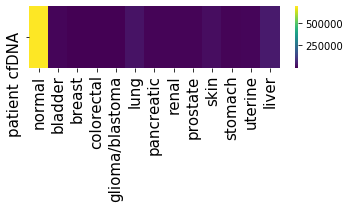

In [132]:
plt.figure(figsize=(5,3))
import seaborn as sns
sns.heatmap(results.reshape([-1,13]), cmap='viridis',yticklabels=['patient cfDNA'],xticklabels=['normal','bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           );
plt.tight_layout()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('patient_1_heatmap.jpg')

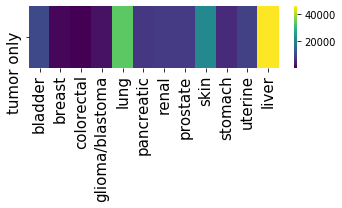

In [133]:
plt.figure(figsize=(5,3))
import seaborn as sns
sns.heatmap(results.reshape([-1,13])[:,1:], yticklabels=['tumor only'],cmap='viridis',xticklabels=['bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           );

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('patient_1_ctDNA_tumors.jpg')

In [124]:
sum_probs = ctDNA_predictions.sum(axis=0)

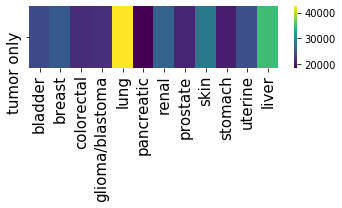

In [134]:
plt.figure(figsize=(5,3))
sns.heatmap(sum_probs.reshape([-1,13])[:,1:], yticklabels=['tumor only'],cmap='viridis',xticklabels=['bladder','breast','colorectal',\
                                               'glioma/blastoma','lung','pancreatic','renal','prostate','skin','stomach','uterine','liver'],
           );

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()
plt.savefig('patient_1_ctDNA_tumors_probs.jpg')

In [721]:
del patient_data, ctDNA_predictions